In [333]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
import os

plt.rcParams["figure.facecolor"] = "w"

import multifreq_correlation as mc
import burst_tools as bt
from importlib import reload
reload(bt)

import sys
sys.path.append("../../include/")
import hhsignal
import hhtools
reload(mc)


with open("./corr_maps.pkl", "rb") as fp:
    corr_map = pkl.load(fp)

fname_th = "./th_data2.pkl"
th_psd, fdir_data = mc.load_psd_threshold(fname_th)
# configuration
nmin_width = int(0.05/th_psd["psd_params"]["mbin_t"])
config = mc.mfoConfig(fdir=fdir_data,
                       std_min=3.3, std_max=8, std_step=0.1,
                       nmin_width=nmin_width,
                       arange=(0.1, 2.1), da=1,
                   **th_psd["psd_params"])
mc.config_params(config)

summary_obj = hhtools.SummaryLoader("../data", load_only_control=True)

In [334]:
def draw_corr_map(corrs, fpsd, axs=None, figsize=(5, 5), dpi=120, vmin=-0.1, vmax=0.1):
    pop_lb = ["F", "S"]
    
    if axs is None:
        plt.figure(dpi=dpi, figsize=figsize)
    for tp in range(4):
        i, j = tp//2, tp%2
        if axs is None:
            plt.subplot(2,2,tp+1)
        else:
            plt.axes(axs[tp])
        if i == 1 and j == 0:
            plt.axis("off")
            continue
            
        im = corrs[:,:,tp].copy()
        hhtools.imshow_xy(im, x=fpsd, y=fpsd, cmap="jet", vmin=vmin, vmax=vmax, interpolation="spline16")
        plt.axis("square")
        ft = np.arange(fpsd[0], fpsd[-1]+5, 20)
        plt.xticks(ft); plt.yticks(ft)
        plt.ylabel(r"$f_{%s}$ (Hz)"%(pop_lb[i]), fontsize=13)
        plt.xlabel(r"$f_{%s}$ (Hz)"%(pop_lb[j]), fontsize=13)
        cbar = plt.colorbar(shrink=0.6, format=lambda x, pos: "{:.1e}".format(x) if x != 0 else "0")
        cbar.ax.locator_params(nbins=3)

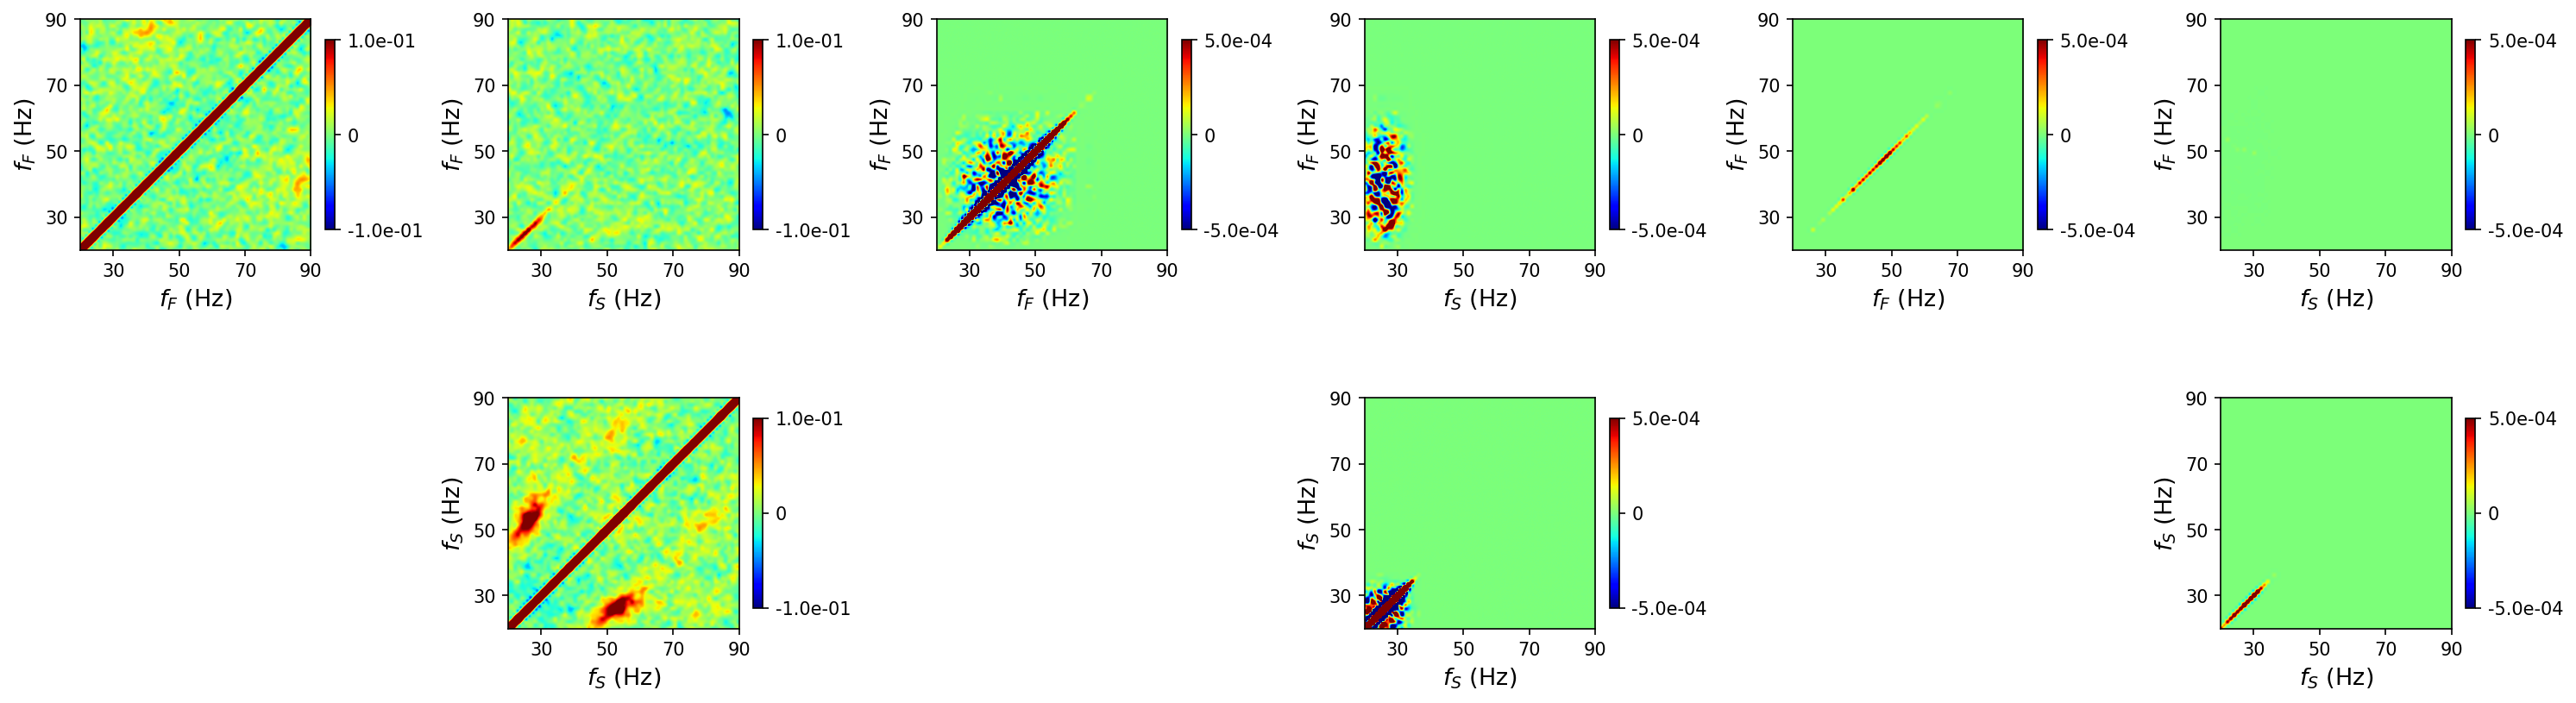

In [511]:
cid = 1

fpsd = np.linspace(10, 100, 90)
fig, axs = plt.subplots(2, 6, dpi=150, figsize=(20, 6))
# pcorr_map
axs_sub = [axs[0][0], axs[0][1], axs[1][0], axs[1][1]]
draw_corr_map(corr_map["pcorr_maps"][cid-1], fpsd, axs=axs_sub, vmin=-0.1, vmax=0.1)

for i in range(2):
    axs_sub = [axs[0][2*(i+1)], axs[0][2*(i+1)+1], axs[1][2*(i+1)], axs[1][2*(i+1)+1]]
    draw_corr_map(corr_map["bcorr_maps"][cid-1][i], fpsd, axs=axs_sub, vmin=-5e-4, vmax=5e-4)

for ax_sub in axs:
    for ax in ax_sub:
        ax.set_xlim([20, 90])
        ax.set_ylim([20, 90])

plt.tight_layout()
plt.show()

### Check single samples 

In [512]:
# Extract all psd_set
from multiprocessing import Pool

def get_bmap(args):
    job_id = args[0]
    fname  = args[1][0]
    th_psd_m = args[1][1]
    th_psd_s = args[1][2]
    
    psd_set, fpsd, tpsd = mc._get_psd_single(fname)
    bmaps, burst_f, burst_range, burst_amps = mc._get_bmap(psd_set, fpsd, th_psd["th_m"][nid, :], th_psd["th_s"][nid, :])
    return job_id, (psd_set, fpsd, tpsd, bmaps, burst_f, burst_range, burst_amps)

args = []
for n in range(summary_obj.num_controls[-1]):
    nid = summary_obj.get_id(cid-1, n)
    fname = os.path.join(summary_obj.fdir, "id%06d_lfp.dat"%(nid))
    args.append((n, (fname, th_psd["th_m"][nid, :], th_psd["th_s"][nid, :])))

with Pool(50) as p:
    outs = p.map(get_bmap, args)
outs = [outs[i][1] for i in np.argsort([o[0] for o in outs])]

psd_stacks  = np.array([o[0] for o in outs])
fpsd, tpsd  = outs[0][1], outs[0][2]
bmap_stacks = np.array([o[3] for o in outs], dtype=int)
burst_f     = [o[4] for o in outs]
burst_range = [o[5] for o in outs]
burst_amps  = [o[6] for o in outs]

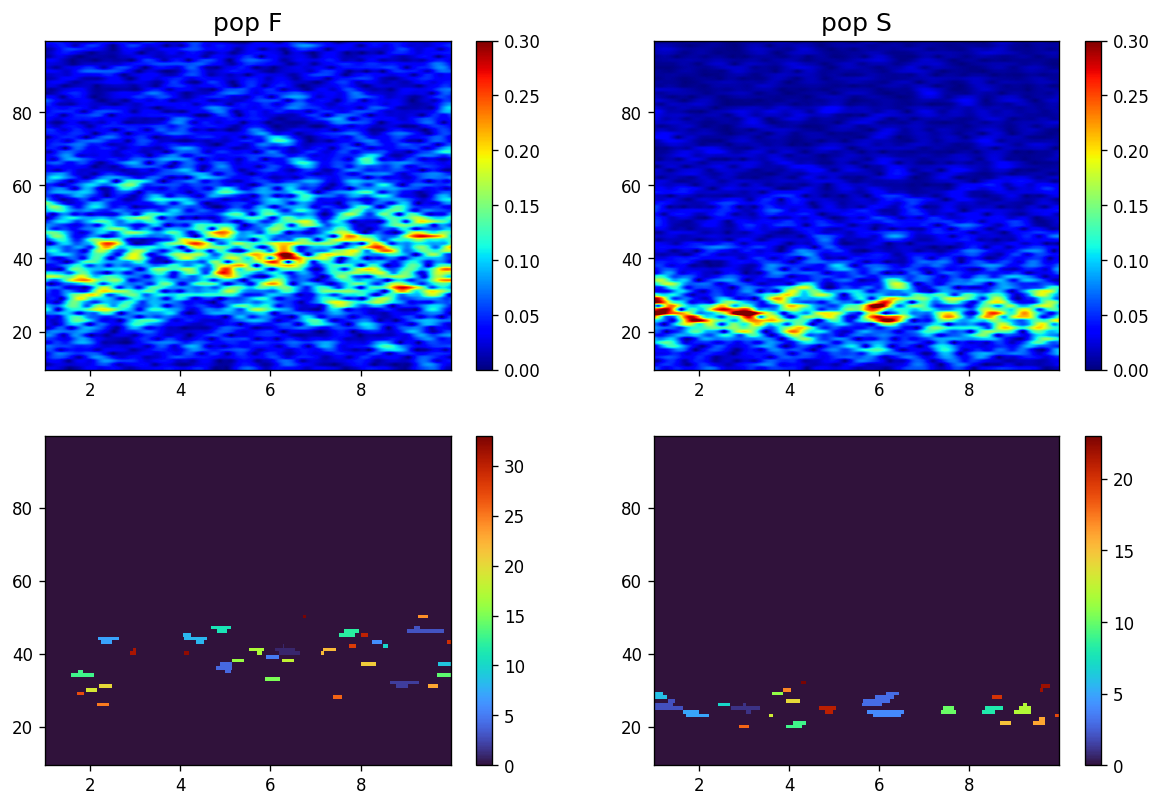

In [513]:
nitr = 10

pop_labels = ("F", "S")

plt.figure(figsize=(12, 8), dpi=120)
for i in range(2):
    plt.subplot(2,2,i+1)
    hhtools.imshow_xy(psd_stacks[nitr][i], x=tpsd, y=fpsd, cmap="jet", vmax=0.3, vmin=0)
    plt.title("pop %s"%(pop_labels[i]), fontsize=15)
    plt.colorbar()
    
    plt.subplot(2,2,i+3)
    hhtools.imshow_xy(bmap_stacks[nitr][i], x=tpsd, y=fpsd, cmap="turbo", interpolation="none")
    plt.colorbar(format=lambda x, pos: "{:.0f}".format(x))
plt.show()

In [514]:
pcorr = np.zeros([len(fpsd), len(fpsd)])
for n in range(psd_stacks.shape[0]):
    psd_set = psd_stacks[n]
    m = np.average(psd_set, axis=2)
    s = np.average(psd_set, axis=2)
    norm_psd_set = (psd_set - m[:,:,np.newaxis]) / s[:,:,np.newaxis]
    
    pcorr += (norm_psd_set[0] @ norm_psd_set[1].T) / psd_stacks.shape[3]
pcorr /= psd_stacks.shape[0]

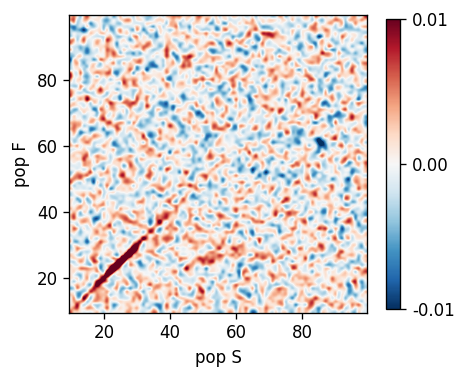

In [515]:
plt.figure(dpi=120, figsize=(4, 4))
# plt.imshow(pcorr, cmap="RdBu_r", vmax=0.01, vmin=-0.01, interpolation="spline16")
hhtools.imshow_xy(pcorr, x=fpsd, y=fpsd, cmap="RdBu_r", vmax=0.01, vmin=-0.01, interpolation="spline16")
plt.ylabel("pop F")
plt.xlabel("pop S")
plt.axis("square")
plt.colorbar(shrink=0.8, format=lambda x, pos: "{:.2f}".format(x), ticks=(-0.01, 0, 0.01))
plt.show()

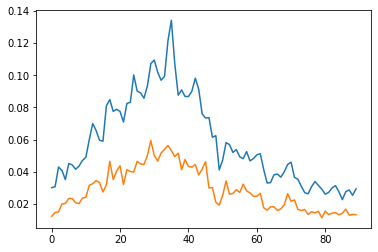

In [555]:

plt.plot(m_psd[0])
plt.plot(s_psd[0])

In [556]:
def get_mask(bmap, brange):
    mask = np.zeros_like(bmap)
    for tp in range(2):
        for br in brange[tp]:
            mask[tp, :, int(br[0]):int(br[1])] = 1
    return mask # 0 (no burst) / 1 (burst exist)

ij_set = ((0, 0), (0, 1), (1, 1))
pcorr_mask = np.zeros([len(fpsd), len(fpsd), 4, 3])
for n in range(psd_stacks.shape[0]):
    psd_set = psd_stacks[n]
    m_psd = np.average(psd_set, axis=2)[:,:,np.newaxis]
    s_psd = np.std(psd_set, axis=2)[:,:,np.newaxis]
    norm_psd_set = (psd_set - m_psd) / s_psd
    # norm_psd_set = psd_set.copy()
    
    # masking
    mask = get_mask(bmap_stacks[n], burst_range[n])
    
    for m in range(4):
        mi, mj = m//2, m%2

        for ntp in range(3):
            i, j = ij_set[ntp]
            mask_i = (mi + mask[i]*(-1)**mi)
            mask_j = (mj + mask[j]*(-1)**mj)
            
            mat_i = norm_psd_set[i] * mask_i
            mat_j = norm_psd_set[j] * mask_j
            n_used = np.sum(mask_i & mask_j) / len(fpsd)
            n_used = 1 if n_used == 0 else n_used
            
            pcorr_mask[:,:,m,ntp] += (mat_i @ mat_j.T)/n_used
            
pcorr_mask /= psd_stacks.shape[0]

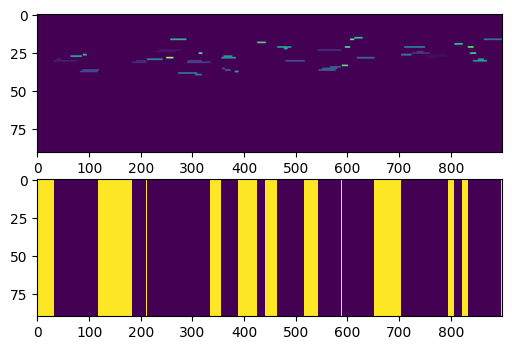

In [557]:
n = 20
mask = get_mask(bmap_stacks[n], burst_range[n])

bt = 1
plt.figure(dpi=100)
plt.subplot(211)
plt.imshow(bmap_stacks[n][0], aspect="auto")

plt.subplot(212)
plt.imshow(bt + mask[0]*(-1)**bt, aspect="auto", interpolation="none")

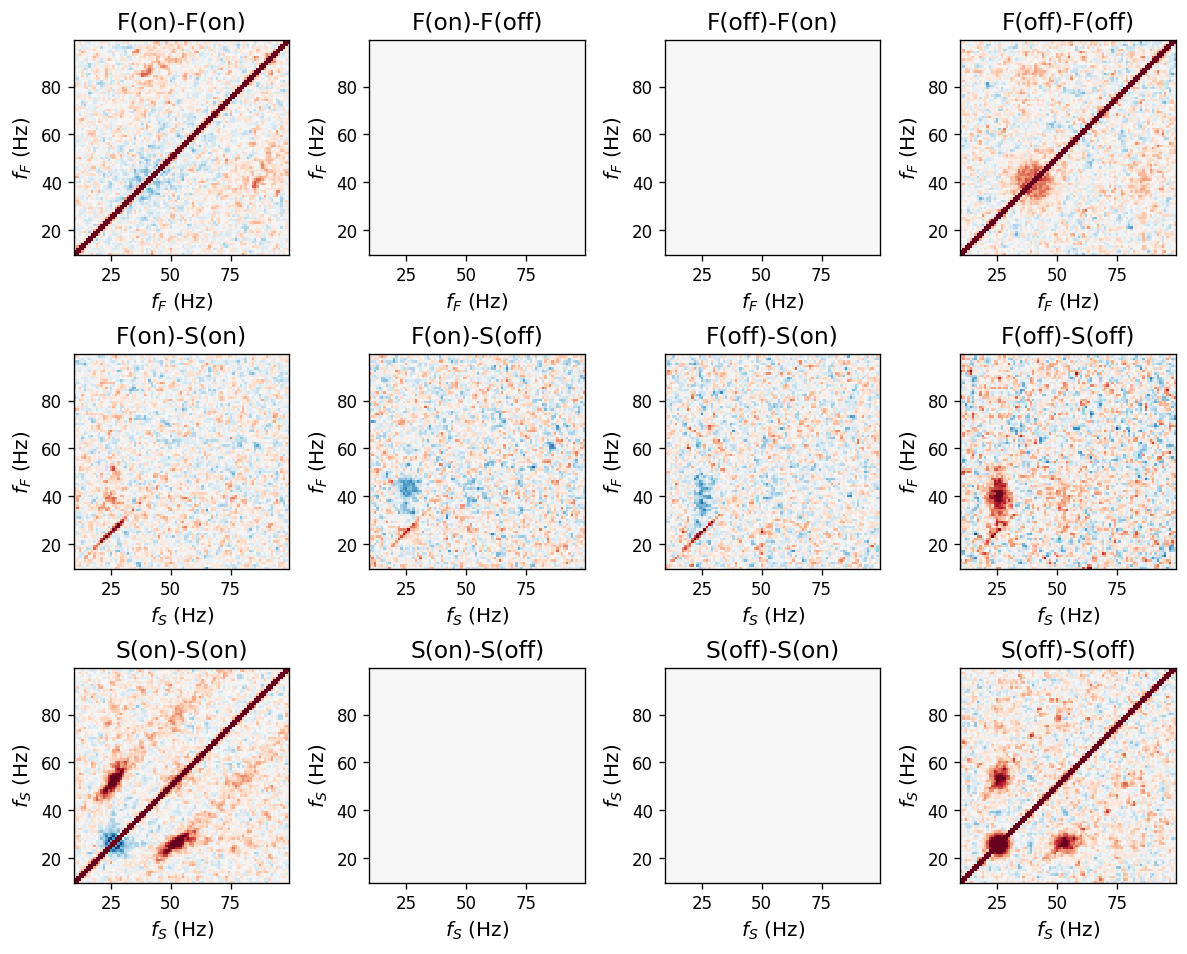

In [558]:
# mask_labels = ("burst exist", "burst vanished")
pop_labels = ("F", "S")
burst_labels = ("on", "off")

plt.figure(dpi=120, figsize=(10, 8))
for bt in range(3):
    for m in range(4):
        plt.subplot(3,4,4*bt+m+1)
        hhtools.imshow_xy(pcorr_mask[:,:,m,bt], x=fpsd, y=fpsd, cmap="RdBu_r", vmax=0.1, vmin=-0.1, interpolation="none")
        plt.axis("square")
        # plt.colorbar(shrink=0.8, format=lambda x, pos: "{:.2f}".format(x), ticks=(-0.02, 0, 0.02))
        plt.title(mask_labels[m], fontsize=13)
        
        i, j = ij_set[bt]
        plt.ylabel(r"$f_{%s}$ (Hz)"%(pop_labels[i]), fontsize=12)
        plt.xlabel(r"$f_{%s}$ (Hz)"%(pop_labels[j]), fontsize=12)
        title = "%s(%s)-%s(%s)"%(pop_labels[i], burst_labels[m//2],
                                 pop_labels[j], burst_labels[m%2])
        plt.title(title, fontsize=14)
plt.tight_layout()
plt.show()

# plt.figure(dpi=120, figsize=(10, 4))
# for m in range(4):
#     plt.subplot(1,4,m+1)
#     hhtools.imshow_xy(pcorr_mask[:,:,m,0], x=fpsd, y=fpsd, cmap="RdBu_r", vmax=0.02, vmin=-0.02, interpolation="none")
#     plt.ylabel(r"$f_{F}$ (Hz)", fontsize=12)
#     plt.xlabel(r"$f_{S}$ (Hz)", fontsize=12)
#     plt.axis("square")
#     # plt.colorbar(shrink=0.8, format=lambda x, pos: "{:.2f}".format(x), ticks=(-0.02, 0, 0.02))
#     plt.title(mask_labels[m], fontsize=13)
# plt.tight_layout()
# # plt.suptitle("PSD correlation map", fontsize=15)
# plt.show()

In [562]:
df = 2
fb_edges = np.arange(np.floor(fpsd[0])-df/2, np.ceil(fpsd[-1])+df, df)

shape = list(bmap_stacks.shape)
shape[2] = len(fb_edges)-1
bmap_shrink_stacks = np.zeros(shape)

for nf in range(len(fb_edges)-1):
    idf = (fpsd >= fb_edges[nf]) & (fpsd < fb_edges[nf+1])
    bmap_shrink_stacks[:,:,nf,:] = np.any(bmap_stacks[:,:,idf,:], axis=2)
    
print("#f: %d -> %d"%(len(fpsd), shape[2]))

#f: 90 -> 46


In [560]:
nfb = shape[2]
fb_psd = (fb_edges[1:] + fb_edges[:-1])/2
len_t = bmap_shrink_stacks.shape[3]

nsample = bmap_shrink_stacks.shape[0]
bcorr_maps = np.zeros([nfb, nfb])
for n in range(nsample):
    i, j = 0, 1
    
    bmap_s = bmap_shrink_stacks[n]
    bc_map = (bmap_s[i] @ bmap_s[j].T) / len_t
    
    p_indep = np.sum(bmap_s, axis=2) / len_t
    pc_indep_map = (p_indep[i, np.newaxis].T @ p_indep[j, np.newaxis])
    
    bcorr_maps += bc_map - pc_indep_map
bcorr_maps /= nsample

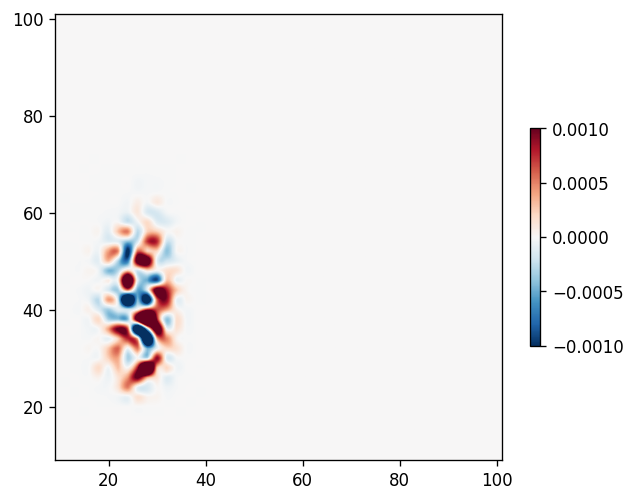

In [561]:
plt.figure(dpi=120, figsize=(6,6))
hhtools.imshow_xy(bcorr_maps, x=fb_psd, y=fb_psd, vmin=-0.001, vmax=0.001, cmap="RdBu_r", interpolation="spline16")
plt.colorbar(shrink=0.4)
plt.axis("square")
plt.show()

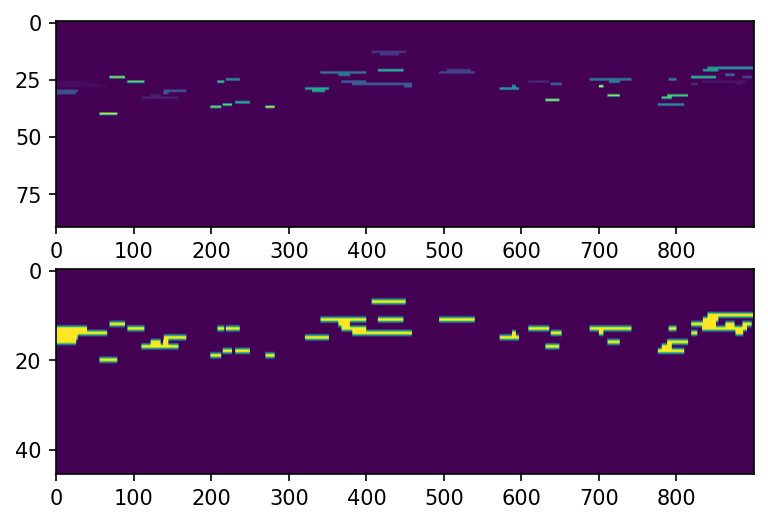

In [523]:
plt.figure(dpi=150)
plt.subplot(211)
plt.imshow(bmap_stacks[0][0], aspect="auto")

plt.subplot(212)
plt.imshow(bmap_shrink_stacks[0][0], aspect="auto")

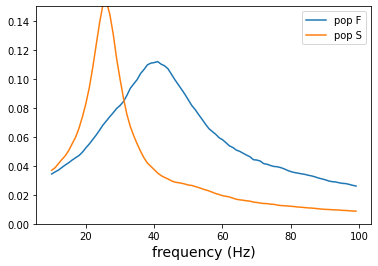

In [563]:
mpsd = np.average(psd_stacks, axis=3)
mpsd = np.average(mpsd, axis=0)

plt.figure()
for tp in range(2):
    plt.plot(fpsd, mpsd[tp], label="pop %s"%(pop_labels[tp]))
plt.xlabel("frequency (Hz)", fontsize=14)
plt.ylim([0, 0.15])
plt.legend(loc="upper right")
plt.show()

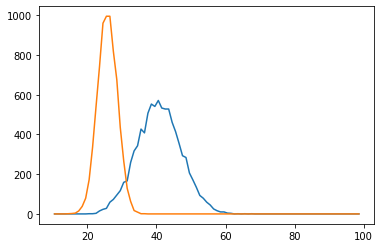

In [564]:
tp = 1

burst_fset = [np.concatenate([f[tp] for f in burst_f]) for tp in range(2)]
x = (fpsd[1:] + fpsd[:-1])/2

plt.figure()
for tp in range(2):
    nbin, _ = np.histogram(burst_fset[tp], fpsd)
    plt.plot(x, nbin, lw=1.5)
plt.show()
    


# plt.figure(dpi=120)
# plt.hist(burst_fset, fpsd)
# plt.xlim([fpsd[0], fpsd[-1]])
# plt.show()

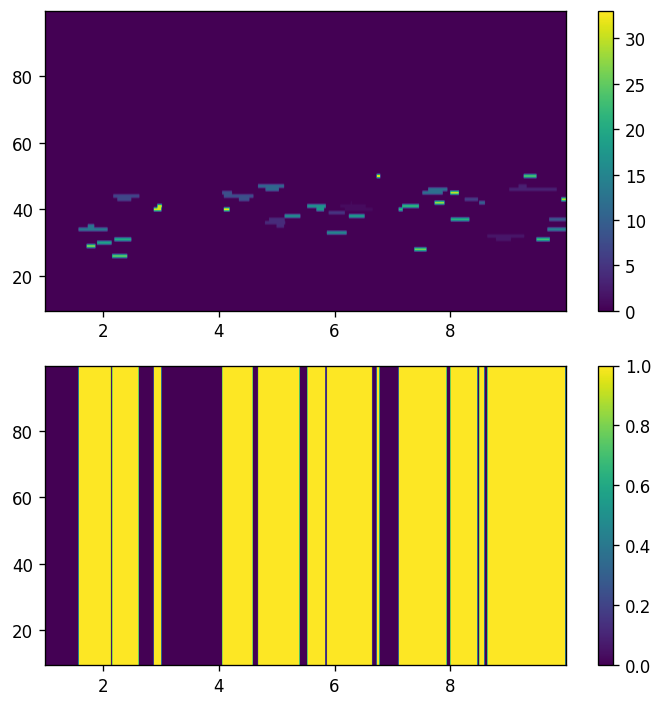

In [526]:
nid = 10
mask = get_mask(bmap_stacks[nid], burst_range[nid])

plt.figure(dpi=120, figsize=(6, 6))
plt.subplot(211)
hhtools.imshow_xy(bmap_stacks[nid, 0], x=tpsd, y=fpsd)
plt.colorbar()

plt.subplot(212)
hhtools.imshow_xy(mask[0], x=tpsd, y=fpsd, vmin=0, vmax=1)
plt.colorbar()

plt.tight_layout()
plt.show()